In [0]:
%tensorflow_version 2.x
import tensorflow as tf


TensorFlow 2.x selected.


In [0]:
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import abc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import pandas as pd
import seaborn as sn
import time


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


170500096/170498071 [==============================] - 2s 0us/step


In [0]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [0]:
tf.keras.backend.set_floatx('float64')

In [0]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer"""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        pass
      

      
class Layer(AbstractLayer):
    """My implementation of Layer."""
    
    def __init__(self, output_size, activation_function, initializer_w, initializer_b):
        super(Layer, self).__init__()
        self.output_size = output_size
        self.activation_function = activation_function
        self.initializer_w = initializer_w
        self.initializer_b = initializer_b

        
    
    def build(self, input_shape):

        self.w = self.add_weight(shape=(input_shape[-1], self.output_size),
                             initializer=self.initializer_w,
                             trainable=True)
        self.b = self.add_weight(shape=(self.output_size,),
                             initializer= self.initializer_b,
                             trainable=True)
        super(AbstractLayer, self).build(input_shape)

        

    def call(self, inputs):
        return self.activation_function(tf.matmul(inputs, self.w) + self.b)


      
class Model(AbstractModel):
    """My implementation of model."""

    def __init__(self, initializer_w = 'random_uniform', initializer_b= 'random_uniform', number_of_layers = 1):
        super(Model, self).__init__()
        self.number_of_layers = number_of_layers
        self.hidden_layers = []
        for i in range(number_of_layers):
          self.hidden_layers.append(Layer(128, tf.keras.activations.relu, initializer_w,initializer_b))
        self.layer2 = Layer(10, tf.keras.activations.softmax, initializer_w,initializer_b)


    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0].numpy()
        vector_size = np.prod(tf.shape(inputs)[1:].numpy())
        inputs = tf.reshape(inputs, [batch_size,vector_size])
        for hl in self.hidden_layers:
          inputs = hl(inputs)
        output2 = self.layer2(inputs)
        return output2
       

    def fit(self, x_train, y_train, epochs=10, lr=0.01,bs=100,**kwargs):
        epochs = epochs
        learning_rate = lr
        optimizer = tf.optimizers.Adam(learning_rate = lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        
        losses=[]
        accuracies = []
        fscores = []
        start_m = time.time()
        
        for e in range(epochs):
          print('epoch:', e)
          start = time.time()
    
          losses_epoch = []
          
          train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
          train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size=bs)
  
          for x, y in train_dataset:  
            with tf.GradientTape() as tape:
              logits = self(x)
              loss_value = loss(y, logits) 
            grads = tape.gradient(loss_value, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
           
            losses_epoch.append(np.mean(loss_value.numpy()))
          
          stop = time.time()
          print('elapsed time:', stop-start)

    
          losses.append(np.mean(losses_epoch))
          pred_after_epoch = self.predict(x_train)
          accuracies.append(accuracy_score(y_train, pred_after_epoch))
          fscores.append(f1_score(y_train, pred_after_epoch, average='macro'))
        
        stop_m = time.time()
        return losses, accuracies, fscores

        
    def predict(self, x):
        out = self(x)
        predicted = tf.math.argmax(out,1)
        return predicted

In [0]:
w_init = 'random_uniform'
b_init = 'random_uniform'
nr_of_layers = 2

In [0]:
model = Model(w_init, b_init, nr_of_layers)

In [0]:
nr_of_hiddel_ls = 5
accs_r=[]
fsc_r=[]
train_metrics=[]
for n in range(1,nr_of_hidden_ls):
  model = Model(w_init, b_init, n)
  model_train_metrics = model.fit(x_train, y_train, lr=0.01, epochs = 10)
  train_metrics.append(model_train_metrics)
  y_pred = model.predict(x_test).numpy()
  a=accuracy_score(y_test, y_pred)
  f=f1_score(y_test, y_pred, average = 'macro')
  accs_r.append(a)
  fsc_r.append(f)
  print(n,a,f)
  

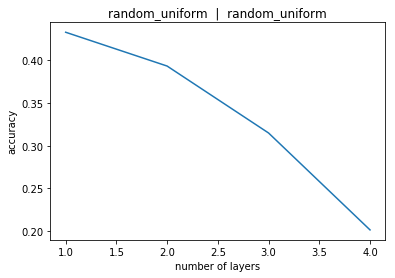

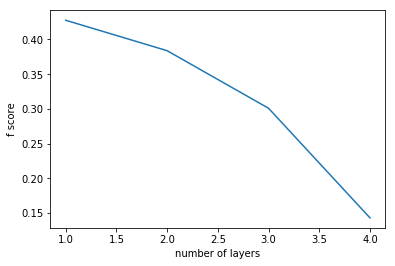

In [0]:
plt.title(w_init + '  |  ' + b_init)
plt.plot([1,2,3,4],accs_r)
plt.xlabel('number of layers')
plt.ylabel('accuracy')
plt.show()
plt.plot([1,2,3,4],fsc_r)
plt.xlabel('number of layers')
plt.ylabel('f score')
plt.show()

number of layers: 1


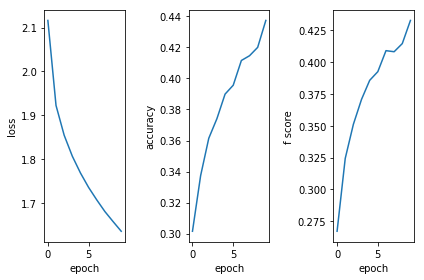

number of layers: 2


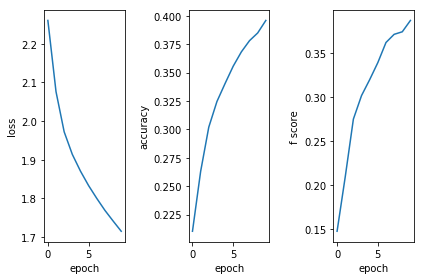

number of layers: 3


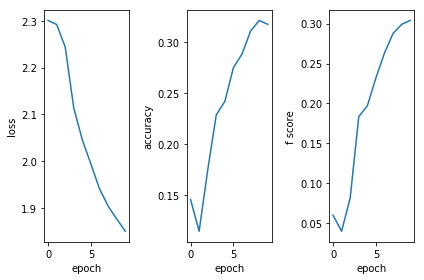

number of layers: 4


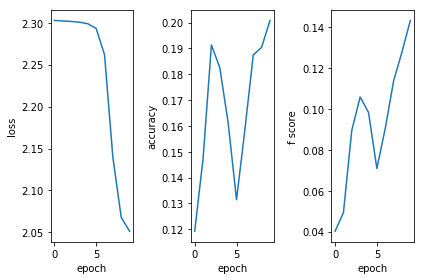

In [0]:
i=1
for train_metric in train_metrics:
  print('number of layers: ' + str(i) + '')
  i+=1

  fig, ax = plt.subplots(1, 3)
  
  for a in ax.flat:
    a.set(xlabel='epoch')
    
  ax[ 0].plot(train_metric[0])
  ax[1].plot(train_metric[1])
  ax[2].plot(train_metric[2])
  
  ax[0].set(ylabel='loss')
  ax[1].set(ylabel='accuracy')
  ax[2].set(ylabel='f score')
  
  plt.tight_layout()

  plt.show()

In [0]:
#testing initializers

initializers = [('ones','ones'), ('ones','zeros'),('zeros','ones'), ('zeros','zeros'),('random_uniform','zeros'),('zeros','random_uniform'),('random_uniform','random_uniform')]

accs_i=[]
fsc_i=[]
train_metrics_init = []
for iw,ib in initializers:
  model = Model(iw, ib, 1)
  mtm = model.fit(x_train, y_train, lr=0.01, epochs = 10)
  train_metrics_init.append(mtm)
  y_pred = model.predict(x_test).numpy()
  a=accuracy_score(y_test, y_pred)
  f=f1_score(y_test, y_pred, average = 'macro')
  accs_i.append(a)
  fsc_i.append(f)
  print(iw,ib,a,f)
  

In [0]:
for i in range(len(initializers)):
  wi, bi = initializers[i]
  print('Initializers: weights:' + wi + ' biases: '+bi)
  print('     accuracy:' + str(accs_i[i]) + ' fscore:'+ str(fsc_i[i]))
  print('\n')

Initializers: weights:ones biases: ones
     accuracy:0.1 fscore:0.01818181818181818


Initializers: weights:ones biases: zeros
     accuracy:0.1 fscore:0.01818181818181818


Initializers: weights:zeros biases: ones
     accuracy:0.1815 fscore:0.112111444574482


Initializers: weights:zeros biases: zeros
     accuracy:0.1 fscore:0.01818181818181818


Initializers: weights:random_uniform biases: zeros
     accuracy:0.4347 fscore:0.4269790861221008


Initializers: weights:zeros biases: random_uniform
     accuracy:0.1892 fscore:0.11214215509566854


Initializers: weights:random_uniform biases: random_uniform
     accuracy:0.4335 fscore:0.4252164751813511




In [0]:
losses = mtm[0]
accuracies = mtm[1]
fscores = mtm[2]


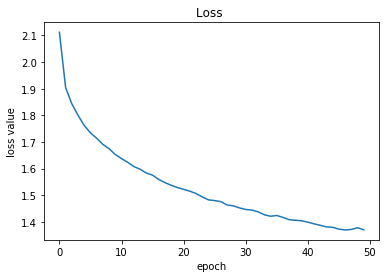

In [0]:
plt.title('Loss ')#' | weight initializer:' + w_init + ' bias initializer:' + b_init)
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

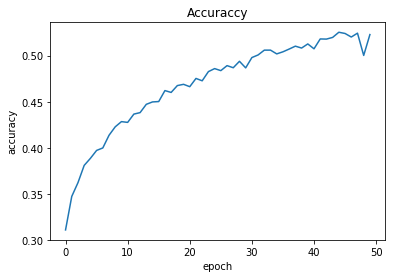

In [0]:
plt.title('Accuraccy')# | weight initializer:' + w_init + ' bias initializer:' + b_init)
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

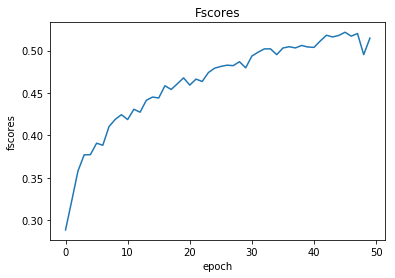

In [0]:
plt.title('Fscores')# | weight initializer:' + w_init + ' bias initializer:' + b_init)
plt.plot(fscores)
plt.xlabel('epoch')
plt.ylabel('fscores')
plt.show()

In [0]:
y_pred = model.predict(x_test).numpy()
accuracy_score(y_test, y_pred)

0.488

In [0]:
cm = confusion_matrix(y_test, y_pred)
cm_norm =cm / cm.sum(axis=1)[:, np.newaxis]


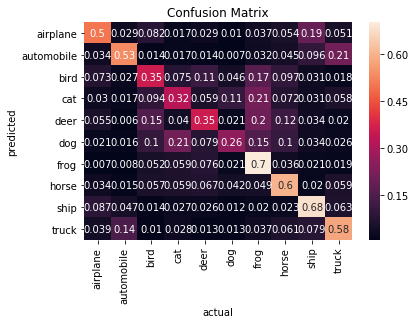

In [0]:
plt.title('Confusion Matrix')
sn.heatmap(cm_norm, annot=True, xticklabels=label_names, yticklabels=label_names)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.show()


In [0]:
def analyze_and_display_mistakes(class_id, N):
  print('----- Mistakes in class:' , label_names[class_id], '----- \n')
  n_mistaken=[]
  i=0
  n=0

  while n<=N:
    if y_test[i][0] ==class_id and y_pred[i] != class_id:
      n_mistaken.append((i,y_pred[i]))
      n+=1
    i+=1

  for pos_id, prediction_id in n_mistaken:
    plt.figure(figsize = (1.5,1.5))
    plt.imshow(x_test[pos_id],interpolation='bicubic')
    plt.show()
    print('classified as: ', label_names[prediction_id], '\n')
   

----- Mistakes in class: airplane ----- 



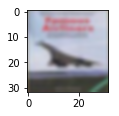

classified as:  ship 



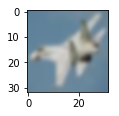

classified as:  ship 



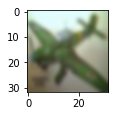

classified as:  bird 



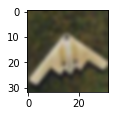

classified as:  frog 



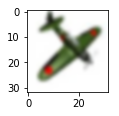

classified as:  bird 

----- Mistakes in class: automobile ----- 



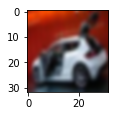

classified as:  cat 



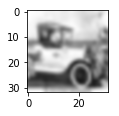

classified as:  ship 



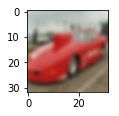

classified as:  truck 



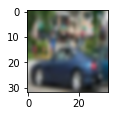

classified as:  truck 



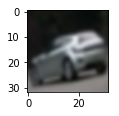

classified as:  horse 

----- Mistakes in class: bird ----- 



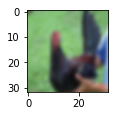

classified as:  frog 



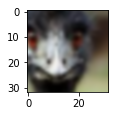

classified as:  automobile 



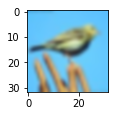

classified as:  ship 



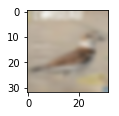

classified as:  deer 



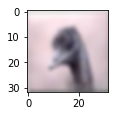

classified as:  airplane 

----- Mistakes in class: cat ----- 



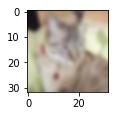

classified as:  deer 



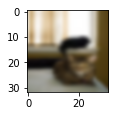

classified as:  truck 



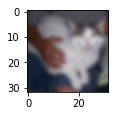

classified as:  dog 



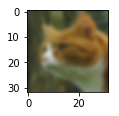

classified as:  frog 



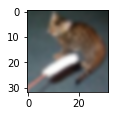

classified as:  dog 

----- Mistakes in class: deer ----- 



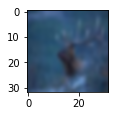

classified as:  airplane 



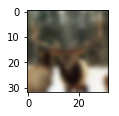

classified as:  frog 



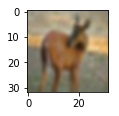

classified as:  frog 



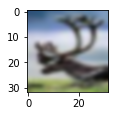

classified as:  airplane 



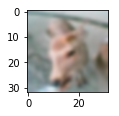

classified as:  ship 

----- Mistakes in class: dog ----- 



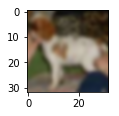

classified as:  cat 



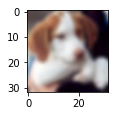

classified as:  horse 



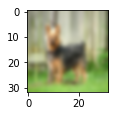

classified as:  deer 



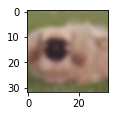

classified as:  deer 



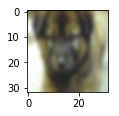

classified as:  cat 

----- Mistakes in class: frog ----- 



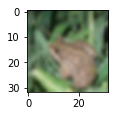

classified as:  deer 



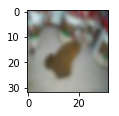

classified as:  bird 



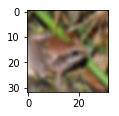

classified as:  deer 



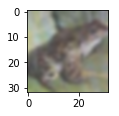

classified as:  bird 



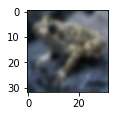

classified as:  ship 

----- Mistakes in class: horse ----- 



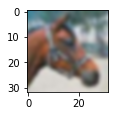

classified as:  frog 



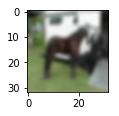

classified as:  deer 



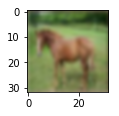

classified as:  deer 



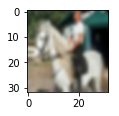

classified as:  dog 



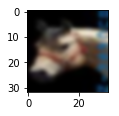

classified as:  frog 

----- Mistakes in class: ship ----- 



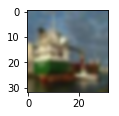

classified as:  horse 



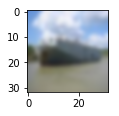

classified as:  airplane 



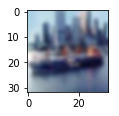

classified as:  truck 



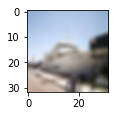

classified as:  truck 



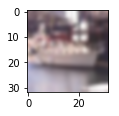

classified as:  cat 

----- Mistakes in class: truck ----- 



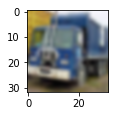

classified as:  automobile 



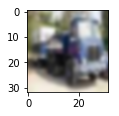

classified as:  automobile 



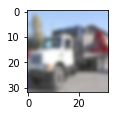

classified as:  ship 



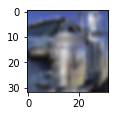

classified as:  ship 



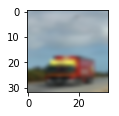

classified as:  ship 



In [0]:
for i in range(len(label_names)):
  analyze_and_display_mistakes(i,4)